# Ingeniería de características

## Contexto
Este notebook forma parte del proyecto de investigación **Construcción de gráfos asistida por LLM**, en donde abordaremos a aprofundidad el dataset de la NHTSA sobre quejas reportadas en vehículos from NHTSA.


## Importación de librerías

In [1]:
import sys
print(sys.executable)

c:\Users\moral\anaconda3\python.exe


In [2]:
import os, gc
import numpy as np
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter


import spacy
from spacy.pipeline import EntityRuler
from spacy import displacy

import pyLDAvis
import inspect

from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore')

# Import our custom EDA class
import sys
sys.path.append('..')
from eda_analysis import ComplaintsEDA

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moral\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moral\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Código de carga y limpieza

In [10]:
# Iniciar limpieza de pipeline
eda = ComplaintsEDA("../data/CMPLT_2025.csv")

# Cargamos nuestros datos limpiando nuestros datos, filtrando por datos recopilados en el año 2025
print("Cargar pipeline de limpieza...")
eda.load_data(filter_year=2025)

# Obtener dataset
df = eda.df

print(f"\nFigura del dataset: {df.shape}")
print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Columnas restantes: {len(df.columns)}")


Cargar pipeline de limpieza...
Loading data...
Aplicando transformacion de datos y limpieza...
  Converted YEAR to numeric
  Converted INJURED to numeric
  Converted DEATHS to numeric
  Converted MILES to numeric
  Converted OCCURENCES to numeric
  Converted VEHSPEED to numeric
  Converted NUMCYLS to numeric
  Converted FAILDATE to datetime
  Converted DATEA to datetime
  Converted LDATE to datetime
  Converted MANUFDATE to datetime
  Normalized text in MFRNAME
  Normalized text in MAKE
  Normalized text in MODEL
  Normalized text in COMPONENT
  Normalized text in CITY
  Normalized text in STATE
  Normalized text in DEALERCITY
  Normalized text in DEALERNAME

APPLYING DATA CLEANING PIPELINE
Original dataset shape: (79376, 49)

1. Removing 1137 rows with YEAR=9999 (tire failures, accessories, unknown products)
   Remaining rows: 78239

2. Removing seat-related columns: ['SEATTYPE', 'RESTRAINTTYPE', 'MANUFDATE']

3. Removing dealer-related columns: ['DEALERTEL', 'DEALERZIP']

4. Removing

In [4]:
# Mostrar información limpia del dataset
print("Cleaned dataset columns:")
print(df.columns.tolist())

print(f"\nDataset info:")
print(f"Shape: {df.shape}")
print(f"Data types:")
print(df.dtypes.value_counts())

# Mostrar rango de fechas en el dataset actual
if 'FAILDATE' in df.columns and len(df) > 0:
    print(f"Date range for 2025: {df['FAILDATE'].min().strftime('%Y-%m-%d')} to {df['FAILDATE'].max().strftime('%Y-%m-%d')}")

# Las columnas vacias ya se eliminaron por medio de nuestra clase ComplaintsEDA
print("Empty columns have already been removed by the cleaning pipeline.")


Cleaned dataset columns:
['CMPLID', 'ODINO', 'MFRNAME', 'MAKE', 'MODEL', 'YEAR', 'CRASH', 'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPONENT', 'CITY', 'STATE', 'VIN', 'DATEA', 'LDATE', 'MILES', 'CMPLDESCR', 'CMPLTYPE', 'POLICERPT', 'ORIGINALOWNER', 'ANTIBRAKES', 'CRUISECONT', 'VEHSPEED', 'DEALERNAME', 'DEALERCITY', 'DEALERSTATE', 'MEDICALATTN', 'VEHICLESTOWED']

Dataset info:
Shape: (59548, 30)
Data types:
object            20
int64              5
datetime64[ns]     3
float64            2
Name: count, dtype: int64
Date range for 2025: 2025-01-01 to 2025-09-18
Empty columns have already been removed by the cleaning pipeline.


## Identificación de variables

In [5]:
print("\n=== Tipos de datos después del pipeline de depuración ===")
print(df.dtypes.value_counts())

print("\n=== Variables numéricas detectadas ===")
print(df.select_dtypes(include=['number']).columns.tolist())

print("\n=== Variables categóricas detectadas ===")
print(df.select_dtypes(include=['object', 'category']).columns.tolist())


=== Tipos de datos después del pipeline de depuración ===
object            20
int64              5
datetime64[ns]     3
float64            2
Name: count, dtype: int64

=== Variables numéricas detectadas ===
['CMPLID', 'ODINO', 'YEAR', 'INJURED', 'DEATHS', 'MILES', 'VEHSPEED']

=== Variables categóricas detectadas ===
['MFRNAME', 'MAKE', 'MODEL', 'CRASH', 'FIRE', 'COMPONENT', 'CITY', 'STATE', 'VIN', 'CMPLDESCR', 'CMPLTYPE', 'POLICERPT', 'ORIGINALOWNER', 'ANTIBRAKES', 'CRUISECONT', 'DEALERNAME', 'DEALERCITY', 'DEALERSTATE', 'MEDICALATTN', 'VEHICLESTOWED']


In [ ]:
df.dtypes

CMPLID                    int64
ODINO                     int64
MFRNAME                  object
MAKE                     object
MODEL                    object
YEAR                      int64
CRASH                    object
FAILDATE         datetime64[ns]
FIRE                     object
INJURED                   int64
DEATHS                    int64
COMPONENT                object
CITY                     object
STATE                    object
VIN                      object
DATEA            datetime64[ns]
LDATE            datetime64[ns]
MILES                   float64
CMPLDESCR                object
CMPLTYPE                 object
POLICERPT                object
ORIGINALOWNER            object
ANTIBRAKES               object
CRUISECONT               object
VEHSPEED                float64
DEALERNAME               object
DEALERCITY               object
DEALERSTATE              object
MEDICALATTN              object
VEHICLESTOWED            object
dtype: object

## Análisis de variables numéricas

¿Cuál es el resumen estadístico del dataset?


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
# Eliminar columnas identificadoras del análisis
identifier_cols = ['CMPLID', 'ODINO']  # Ambas son identificadores, no variables analíticas
for col in identifier_cols:
    if col in numeric_cols:
        numeric_cols = numeric_cols.drop(col)

# Tipos de datos e información básica
print(f"Tipos de datos:")
print(df.dtypes.value_counts())

print(f"\nColumnas numéricas ({len(numeric_cols)}):")
print(numeric_cols.tolist())

if len(numeric_cols) > 0:
    print("\nEstadísticas Resumidas Numéricas:")
    print(df[numeric_cols].describe())
    
    # Estadísticas adicionales
    print("\nEstadísticas Adicionales:")
    numeric_stats = pd.DataFrame({
        'Asimetría': df[numeric_cols].skew(),
        'Curtosis': df[numeric_cols].kurtosis(),
        'Varianza': df[numeric_cols].var(),
        'Coef_Variación': df[numeric_cols].std() / df[numeric_cols].mean()
    })
    print(numeric_stats)


Tipos de datos:
object            20
int64              5
datetime64[ns]     3
float64            2
Name: count, dtype: int64

Columnas numéricas (5):
['YEAR', 'INJURED', 'DEATHS', 'MILES', 'VEHSPEED']

Estadísticas Resumidas Numéricas:
               YEAR       INJURED        DEATHS          MILES      VEHSPEED
count  59548.000000  59548.000000  59548.000000    9408.000000  29747.000000
mean    2019.106469      0.030580      0.001226   86651.384673     34.995966
std        4.259369      0.245171      0.110030   59157.986073     32.301967
min     1986.000000      0.000000      0.000000       0.000000      0.000000
25%     2017.000000      0.000000      0.000000   45000.000000      5.000000
50%     2020.000000      0.000000      0.000000   81000.000000     35.000000
75%     2022.000000      0.000000      0.000000  120000.000000     60.000000
max     2026.000000     10.000000     15.000000  763309.000000    999.000000

Estadísticas Adicionales:
           Asimetría      Curtosis      Var

## Análisis de variables categóricas

¿Cuál es el comportamiento de las variables descriptivas? ¿Se pueden incluir en nuestro análisis de correlación relaciando por medio de alguna codificación numérica? (Por ejemplo: One Hot Encoding)


In [8]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()


rows = []
for c in cat_cols:
        n = len(df)
        nunique = df[c].nunique(dropna=True)
        missing = df[c].isna().sum()
        missing_pct = 100.0 * missing / n
        top_vals = df[c].value_counts(dropna=False).head(5)
        rows.append({
            "column": c,
            "dtype": str(df[c].dtype),
            "n_unique": nunique,
            "missing": missing,
            "missing_pct": round(missing_pct, 2),
            "top_values_preview": "; ".join([f"{k}:{v}" for k,v in top_vals.items()])
        })

summary = pd.DataFrame(rows).sort_values(["n_unique","missing_pct","column"])
print("\n=== Resumen de variables categóricas ===")
print(summary[["column","dtype","n_unique","missing","missing_pct"]])


=== Resumen de variables categóricas ===
           column   dtype  n_unique  missing  missing_pct
10       CMPLTYPE  object         2        0         0.00
3           CRASH  object         2        0         0.00
4            FIRE  object         2        0         0.00
18    MEDICALATTN  object         2        0         0.00
11      POLICERPT  object         2        0         0.00
13     ANTIBRAKES  object         2       17         0.03
14     CRUISECONT  object         2       17         0.03
12  ORIGINALOWNER  object         2       17         0.03
19  VEHICLESTOWED  object         2       17         0.03
17    DEALERSTATE  object        53    54269        91.13
7           STATE  object        58        0         0.00
0         MFRNAME  object       117        0         0.00
1            MAKE  object       147        0         0.00
5       COMPONENT  object       344        0         0.00
2           MODEL  object      1106        0         0.00
16     DEALERCITY  object     

ANALISIS DE CORRELACION CON VARIABLES CATEGORICAS

=== Cardinalidad de las variables categóricas ===
CRASH: 2
FIRE: 2
CMPLTYPE: 2
POLICERPT: 2
ORIGINALOWNER: 2
ANTIBRAKES: 2
CRUISECONT: 2
MEDICALATTN: 2
VEHICLESTOWED: 2
DEALERSTATE: 53
STATE: 58
MFRNAME: 117
MAKE: 147
COMPONENT: 344
MODEL: 1106
DEALERCITY: 1873
DEALERNAME: 3909
CITY: 8160
VIN: 29445
CMPLDESCR: 40815

Variables categóricas seleccionadas (14):
['MFRNAME', 'MAKE', 'CRASH', 'FIRE', 'COMPONENT', 'STATE', 'CMPLTYPE', 'POLICERPT', 'ORIGINALOWNER', 'ANTIBRAKES', 'CRUISECONT', 'DEALERSTATE', 'MEDICALATTN', 'VEHICLESTOWED']

Codificando 14 variables categóricas...
  MFRNAME: 117 unique values
    ✓ Codificada MFRNAME (top 20 categories only)
  MAKE: 147 unique values
    ✓ Codificada MAKE (top 20 categories only)
  CRASH: 2 unique values
    ✓ Encoded CRASH
  FIRE: 2 unique values
    ✓ Encoded FIRE
  COMPONENT: 344 unique values
    ✓ Codificada COMPONENT (top 20 categories only)
  STATE: 58 unique values
    ✓ Encoded STATE
  

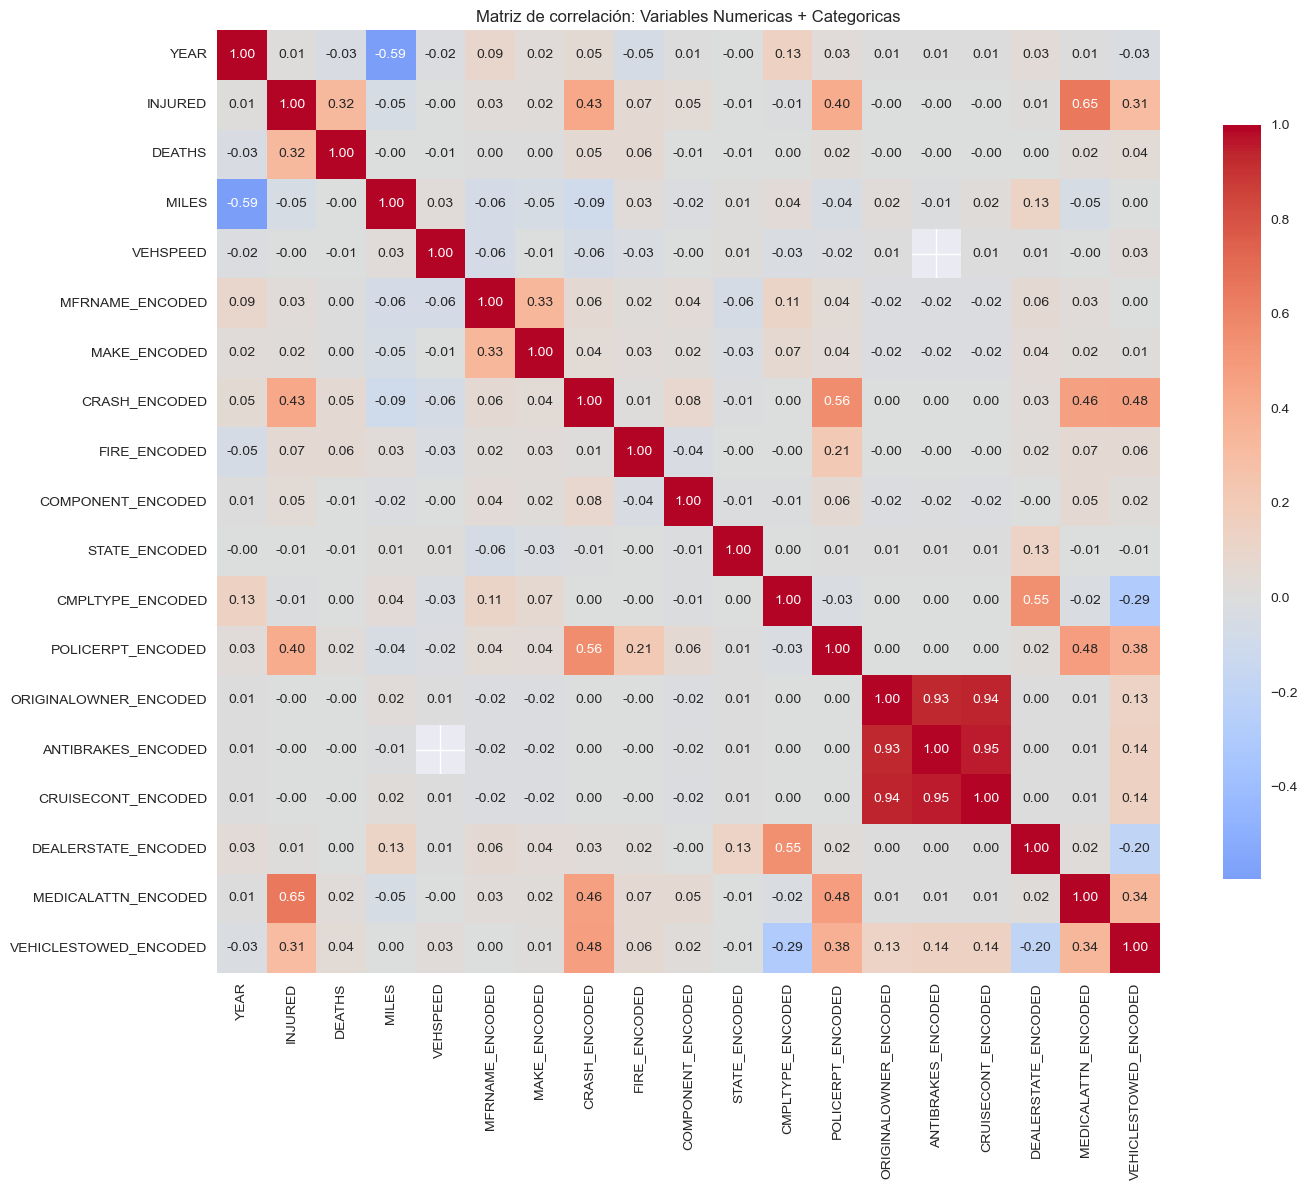


Correlación entre variables numericas and categoricas:
  INJURED vs CRASH: r = 0.426
  INJURED vs POLICERPT: r = 0.400
  INJURED vs MEDICALATTN: r = 0.651
  INJURED vs VEHICLESTOWED: r = 0.306

Correlaciones significativas (|r| > 0.5):
               Variable1            Variable2  Correlación
6     ANTIBRAKES_ENCODED   CRUISECONT_ENCODED     0.951056
5  ORIGINALOWNER_ENCODED   CRUISECONT_ENCODED     0.938111
4  ORIGINALOWNER_ENCODED   ANTIBRAKES_ENCODED     0.931571
1                INJURED  MEDICALATTN_ENCODED     0.651325
0                   YEAR                MILES    -0.594482
2          CRASH_ENCODED    POLICERPT_ENCODED     0.563065
3       CMPLTYPE_ENCODED  DEALERSTATE_ENCODED     0.547032


In [9]:
print("ANALISIS DE CORRELACION CON VARIABLES CATEGORICAS")

# Determinar cardinalidad por variable
cardinalities = {col: df[col].nunique() for col in cat_cols}
print("\n=== Cardinalidad de las variables categóricas ===")
for col, val in sorted(cardinalities.items(), key=lambda x: x[1]):
    print(f"{col}: {val}")

# Seleccionar variables con cardinalidad manejable
# - Binarias (2 valores) y bajas/medias (<= 500)
available_categorical = [col for col, n in cardinalities.items() if 2 <= n <= 500]

print(f"\nVariables categóricas seleccionadas ({len(available_categorical)}):")
print(available_categorical)

if not available_categorical:
    print("No se encontraron variables categóricas adecuadas para codificación.")
else:
    print(f"\nCodificando {len(available_categorical)} variables categóricas...")
    df_encoded = df.copy()
    
    # Create a copy for encoding
    df_encoded = df.copy()
    
    # Method 1: Label Encoding (simple numerical assignment)
    
    le = LabelEncoder()
    
    encoded_cols = []
    for col in available_categorical:
        # Check unique values first
        unique_count = df_encoded[col].nunique()
        print(f"  {col}: {unique_count} unique values")
        
        # Try encoding with higher threshold or use top categories
        if unique_count <= 100:  # Increased threshold
            df_encoded[f"{col}_ENCODED"] = le.fit_transform(df_encoded[col].astype(str))
            encoded_cols.append(f"{col}_ENCODED")
            print(f"    ✓ Encoded {col}")
        elif unique_count <= 500:  # For medium cardinality, use top categories
            # Get top 20 categories and encode only those
            top_categories = df_encoded[col].value_counts().head(20).index
            df_encoded[f"{col}_ENCODED"] = df_encoded[col].apply(
                lambda x: top_categories.get_loc(x) if x in top_categories else -1
            )
            encoded_cols.append(f"{col}_ENCODED")
            print(f"    ✓ Codificada {col} (top 20 categories only)")
        else:
            print(f"    ✗ Skipped {col} (muchos valores únicos: {unique_count})")
    
    if not encoded_cols:
        print("No se detectaron variables categoricas para hacer one hot encoding con el umbral actual")
        
        # Alternative: Force encode top categories for each variable
        for col in available_categorical:
            top_categories = df_encoded[col].value_counts().head(10).index
            df_encoded[f"{col}_ENCODED"] = df_encoded[col].apply(
                lambda x: list(top_categories).index(x) if x in top_categories else -1
            )
            encoded_cols.append(f"{col}_ENCODED")
            print(f"  ✓ Force encoded {col} (top 10 categories only)")
    
    if not encoded_cols:
        print("No se encontrar variables para hacer un encoded.")
    else:
        # Combine numerical and encoded categorical columns
        all_corr_cols = numeric_cols.tolist() + encoded_cols
        
        # Calculate correlation matrix
        corr_data = df_encoded[all_corr_cols].select_dtypes(include=[np.number])
        correlation_matrix = corr_data.corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(15, 12))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Matriz de correlación: Variables Numericas + Categoricas')
        plt.tight_layout()
        plt.show()
        
        # Find correlations between numerical and categorical variables
        print("\nCorrelación entre variables numericas and categoricas:")
        for num_col in numeric_cols:
            for cat_col in encoded_cols:
                if num_col in correlation_matrix.columns and cat_col in correlation_matrix.columns:
                    corr_val = correlation_matrix.loc[num_col, cat_col]
                    if abs(corr_val) > 0.3:  # Lower threshold for categorical
                        print(f"  {num_col} vs {cat_col.replace('_ENCODED', '')}: r = {corr_val:.3f}")
        
        # Find high correlations among all variables
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.5:  # Lower threshold for mixed analysis
                    high_corr_pairs.append({
                        'Variable1': correlation_matrix.columns[i],
                        'Variable2': correlation_matrix.columns[j],
                        'Correlación': corr_val
                    })
        
        if high_corr_pairs:
            print(f"\nCorrelaciones significativas (|r| > 0.5):")
            high_corr_df = pd.DataFrame(high_corr_pairs)
            print(high_corr_df.sort_values('Correlación', key=abs, ascending=False))
        else:
            print("\nNo se encontró correlación significativa (|r| > 0.5)")


# Descripción de quejas

¿Cuáles son las características de las quejas? ¿Qué patrones podemos identificar en el texto?


## Limpieza del corpus

Se eliminarán stop words más otras palabras comunos que se han encontrado en nuestro cuerpo de texto, las cuales no aportan conocimiento y es información duplicada.

In [11]:
# Iniciar limpieza de corpus con stopwords
custom_stop = {"redacted","pursuant","freedom","information","act","xxx"}
stop_words = set(stopwords.words('english')) | custom_stop

lemmatizer = WordNetLemmatizer()

FOIA_REGEX = re.compile(
    r"\binformation\s+redacted\b.*?\bfreedom\s+of\s+information\s+act\b",
    flags=re.IGNORECASE
)

def strip_boilerplate(text: str) -> str:
    if not isinstance(text, str): return ""
    # 1) quita bloque FOIA completo (oraciones)
    txt = FOIA_REGEX.sub(" ", text)
    # 2) normaliza placeholders [XXX] o variantes
    txt = re.sub(r"\[+\s*xxx\s*\]+", " ", txt, flags=re.IGNORECASE)
    txt = re.sub(r"\bxxx\b", " ", txt, flags=re.IGNORECASE)
    # 3) espacios extra
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

df["CMPLDESCR_CLEAN1"] = df["CMPLDESCR"].fillna("").apply(strip_boilerplate)

TEXT_COL = next((c for c in ['CMPLDESCR_CLEAN1'] if c in df.columns), None)
assert TEXT_COL is not None, "No se encontró columna de texto."

def clean_text_keep_nums(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)   # letras, números y espacios
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words
             if (w not in stop_words) and (len(w) > 2 or w.isdigit())]
    return " ".join(words)

if TEXT_COL != 'CLEAN_TEXT':
    df['CLEAN_TEXT'] = df[TEXT_COL].fillna("").apply(clean_text_keep_nums).str.lower()
else:
    df['CLEAN_TEXT'] = df['CLEAN_TEXT'].fillna("")

### Text Corpus Analysis - CMPLDESCR


TEXT CORPUS ANALYSIS - CMPLDESCR
Total de quejas: 59548
Quejas con descripciones: 59548
Descripciones faltantes: 0
Completitud de descripciones: 100.00%

Estadísticas de Longitud de Texto:
  Longitud media: 423.5 caracteres
  Mediana: 353.0 caracteres
  Longitud mínima: 0 caracteres
  Longitud máxima: 1693 caracteres
  Desviación estándar: 320.3 caracteres

Estadísticas de Conteo de Palabras:
  Promedio de palabras: 60.1
  Mediana de palabras: 50.0
  Mínimo de palabras: 0
  Máximo de palabras: 250


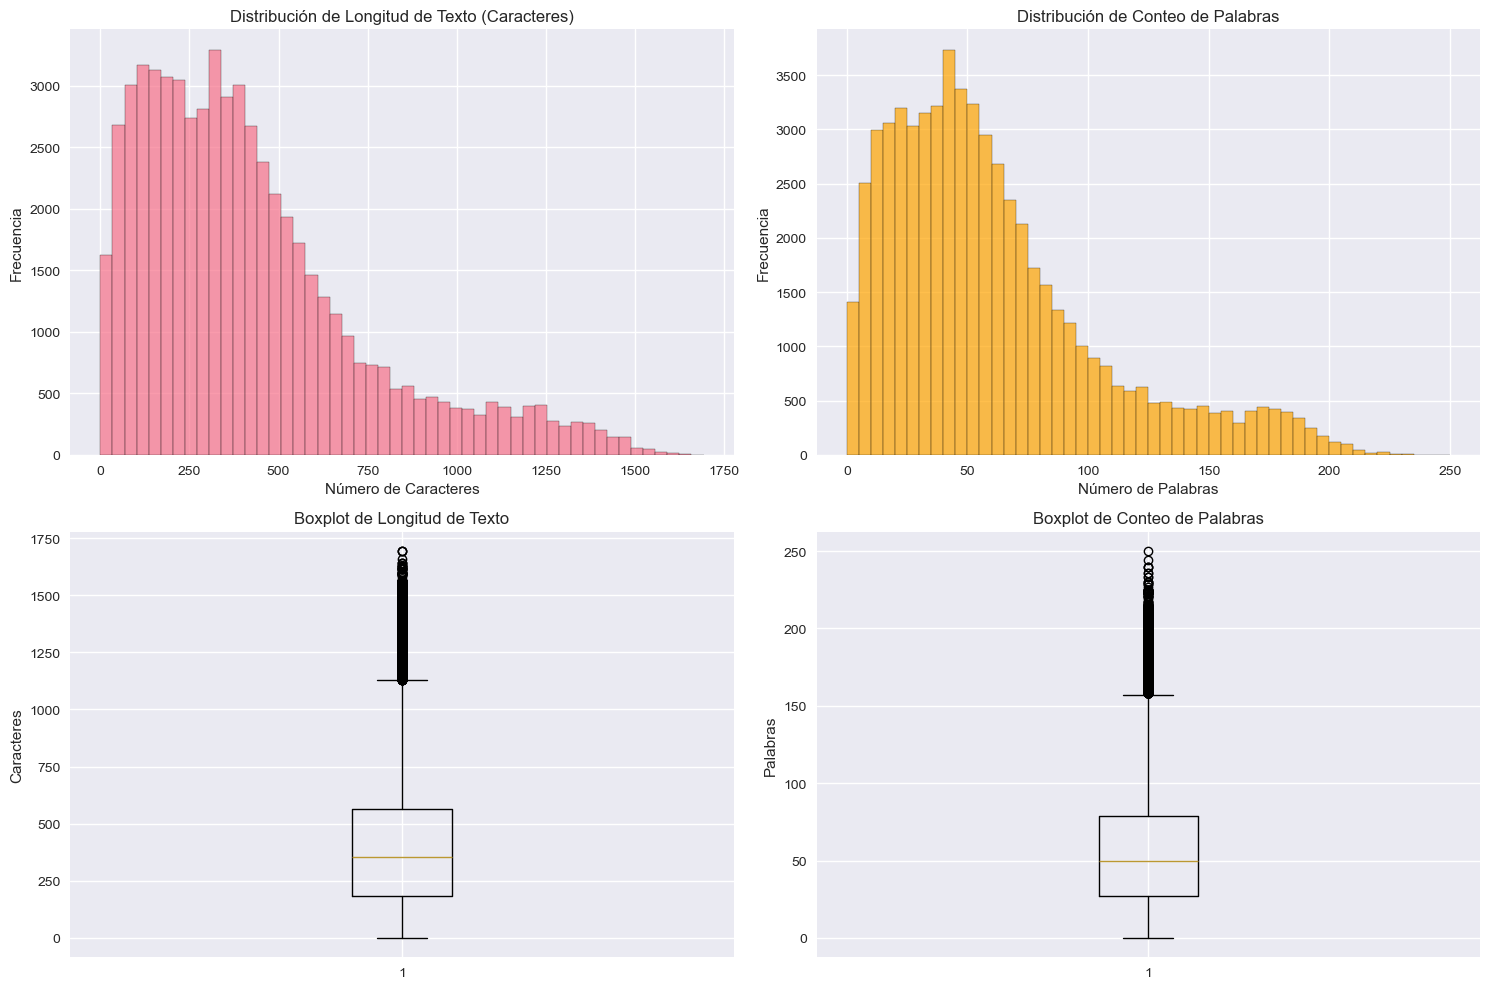

In [ ]:
# Análisis del texto limpio 

if 'CLEAN_TEXT' not in df.columns:
    print("Columna CLEAN_TEXT no encontrada en el dataset")
else:
    # Estadísticas básicas de texto
    text_col = df['CLEAN_TEXT']
    non_null_texts = text_col.dropna()
    
    print(f"Total de quejas: {len(df)}")
    print(f"Quejas con descripciones: {len(non_null_texts)}")
    print(f"Descripciones faltantes: {len(df) - len(non_null_texts)}")
    print(f"Completitud de descripciones: {len(non_null_texts)/len(df)*100:.2f}%")
    
    if len(non_null_texts) > 0:
        # Análisis de longitud de texto
        text_lengths = non_null_texts.str.len()
        print(f"\nEstadísticas de Longitud de Texto:")
        print(f"  Longitud media: {text_lengths.mean():.1f} caracteres")
        print(f"  Mediana: {text_lengths.median():.1f} caracteres")
        print(f"  Longitud mínima: {text_lengths.min()} caracteres")
        print(f"  Longitud máxima: {text_lengths.max()} caracteres")
        print(f"  Desviación estándar: {text_lengths.std():.1f} caracteres")
        
        # Análisis de conteo de palabras
        word_counts = non_null_texts.str.split().str.len()
        print(f"\nEstadísticas de Conteo de Palabras:")
        print(f"  Promedio de palabras: {word_counts.mean():.1f}")
        print(f"  Mediana de palabras: {word_counts.median():.1f}")
        print(f"  Mínimo de palabras: {word_counts.min()}")
        print(f"  Máximo de palabras: {word_counts.max()}")
        
        # Visualizar características del texto
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Distribución de longitud de caracteres
        axes[0,0].hist(text_lengths, bins=50, alpha=0.7, edgecolor='black')
        axes[0,0].set_title('Distribución de Longitud de Texto (Caracteres)')
        axes[0,0].set_xlabel('Número de Caracteres')
        axes[0,0].set_ylabel('Frecuencia')
        
        # Distribución de conteo de palabras
        axes[0,1].hist(word_counts, bins=50, alpha=0.7, edgecolor='black', color='orange')
        axes[0,1].set_title('Distribución de Conteo de Palabras')
        axes[0,1].set_xlabel('Número de Palabras')
        axes[0,1].set_ylabel('Frecuencia')
        
        # Diagrama de caja para longitud de texto
        axes[1,0].boxplot(text_lengths)
        axes[1,0].set_title('Boxplot de Longitud de Texto')
        axes[1,0].set_ylabel('Caracteres')
        
        # Diagrama de caja para conteo de palabras
        axes[1,1].boxplot(word_counts)
        axes[1,1].set_title('Boxplot de Conteo de Palabras')
        axes[1,1].set_ylabel('Palabras')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No hay descripciones de texto disponibles para análisis")



### Word Frequency Analysis


----------------------------------------
TEXT PATTERNS BY VARIABLES
----------------------------------------


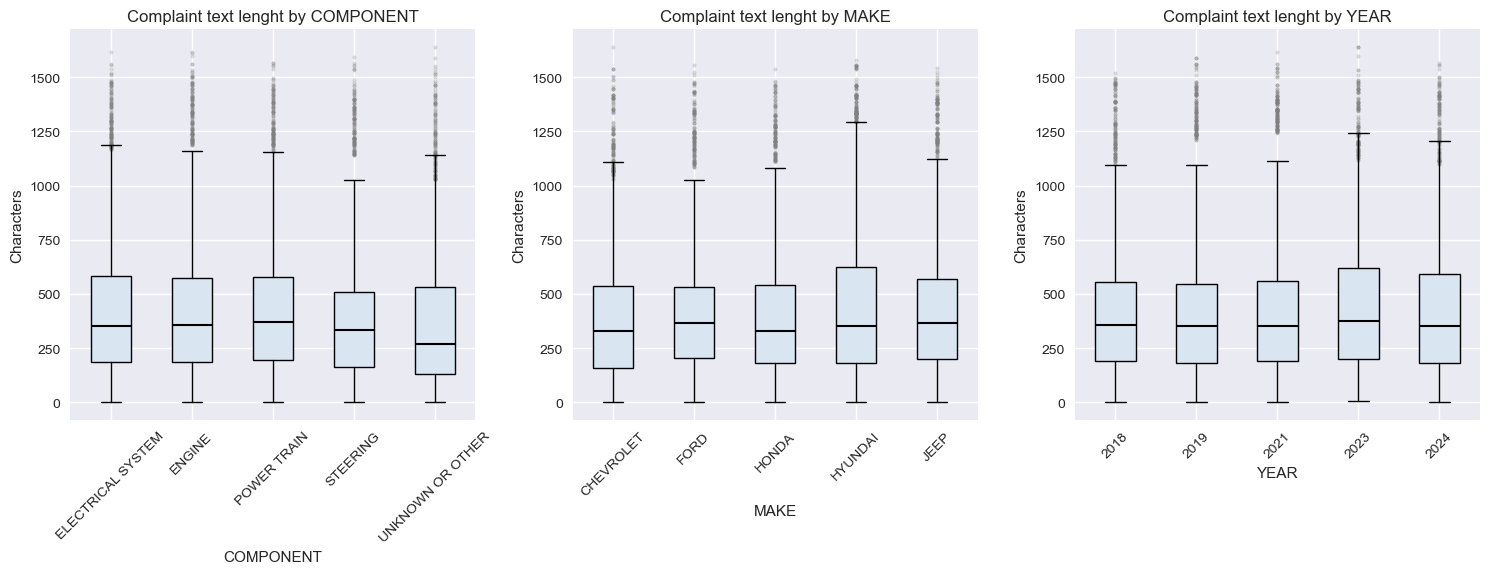


Ejemplos de quejas:

Complaint 1:
Length: 80 characters
Text: tailgate release multiple time day hear attempt light flash drained battery also

Complaint 2:
Length: 422 characters
Text: vehicle 45 000 mile right rear wheel bearing failed covered 5 year 60 000 mile warranty repaired today certified subaru dealer longer bad part inspection safety risk would anything occurs bad wheel bearing like wobble seizing overheating damage drivetrain component could hear wheel bearing noise 20 mph constant driving getting louder increased speed warning light present dash feel like 45 000 mile...

Complaint 3:
Length: 791 characters
Text: combustion engine sporadically fails start combustion engine longer started start stop function sporadically unavailable ready displayed yellow instrument cluster start stop function fails function properly dangerous road condition pulling intersection stop traffic proceeding stop light etc second time major incident occurred repaired december 2020 manufacturer wa

In [20]:
TEXT_COL = next((c for c in ['CLEAN_TEXT'] if c in df.columns), None)
if TEXT_COL is None:
    print("⚠️ No se encontró columna de texto (CMPLDESCR/CDESCR/DESCRIPTION).")
else:
    print("\n" + "-"*40)
    print("TEXT PATTERNS BY VARIABLES")
    print("-"*40)

    # Subconjunto con texto no nulo
    text_df = df[df[TEXT_COL].notna()].copy()

    # Asegurar string
    text_df[TEXT_COL] = text_df[TEXT_COL].astype(str)

    # Métricas de texto
    text_df['TEXT_LENGTH'] = text_df[TEXT_COL].str.len()
    text_df['WORD_COUNT']  = text_df[TEXT_COL].str.split().str.len()

    # Variables categóricas clave (si existen)
    key_vars = ['COMPONENT', 'MAKE', 'YEAR']
    available_vars = [v for v in key_vars if v in text_df.columns]

    if available_vars:
        fig, axes = plt.subplots(1, len(available_vars), figsize=(5*len(available_vars), 6))
        if len(available_vars) == 1:
            axes = [axes]

        for i, var in enumerate(available_vars):
            top = text_df[var].value_counts().head(5).index
            subset = text_df[text_df[var].isin(top)]

            subset.boxplot(
                column='TEXT_LENGTH', by=var, ax=axes[i],
                showfliers=False, patch_artist=True,
                boxprops=dict(facecolor='#d9e6f2'),
                medianprops=dict(color='black', linewidth=1.5),
                whiskerprops=dict(linewidth=1), capprops=dict(linewidth=1)
    )

            # Añadir “algunos” outliers por categoría (p. ej. 150 puntos máximo)
            for cat in top:
                y = subset.loc[subset[var] == cat, 'TEXT_LENGTH'].values
                q1, q3 = np.percentile(y, [25, 75])
                iqr = q3 - q1
                out = y[(y < q1 - 1.5*iqr) | (y > q3 + 1.5*iqr)]
                if len(out) > 0:
                    samp = np.random.choice(out, size=min(150, len(out)), replace=False)
                    x = np.full_like(samp, fill_value=list(top).index(cat)+1, dtype=float)
                    axes[i].scatter(x, samp, s=6, alpha=0.25, c='gray')  # puntos suaves

            axes[i].set_title(f'Complaint text lenght by {var}')
            axes[i].set_xlabel(var); axes[i].set_ylabel('Characters')
            axes[i].tick_params(axis='x', rotation=45)

        # Quita el suptitle automático de pandas
        plt.suptitle('')
        plt.tight_layout()
        plt.show()
    else:
        print("No hay variables categóricas disponibles entre MAKE/COMPONENT/STATE para graficar.")

    # --- Ejemplos de quejas ---
    print("\nEjemplos de quejas:")
    print("="*50)

    # Opción de textos aleatorios
    examples = text_df[TEXT_COL].sample(min(3, len(text_df)), random_state=42)

    for i, txt in enumerate(examples, 1):
        preview = txt[:400] + ("..." if len(txt) > 400 else "")
        print(f"\nComplaint {i}:")
        print(f"Length: {len(txt)} characters")
        print(f"Text: {preview}")

## Deduplicado de quejas para LDA

Para que nuestro análisis de tópicos no se vea afectado por los duplicados, crearemos otro dataframe manteniendo una sola descripción por queja y se consolidarán los componentes.



In [12]:
n_rows = len(df)

# Elegimos el ID de caso: prioriza ODINO
case_id_col = 'ODINO' if 'ODINO' in df.columns else ('CMPLID' if 'CMPLID' in df.columns else None)
assert case_id_col is not None, "No se encontró ODINO/CMPLID para agrupar casos."

# Selecciona para cada caso el texto más largo ya limpio (CLEAN_TEXT),
# y agrega la lista única de componentes.
df['_TEXT_LEN'] = df['CLEAN_TEXT'].fillna("").str.len()

# Índice de la fila con texto más largo por caso
idx_longest = df.groupby(case_id_col)['_TEXT_LEN'].idxmax()

# Arma el dataframe agregado
complaints_agg = (
    df.loc[idx_longest, [case_id_col, 'CLEAN_TEXT']]
      .merge(
          df.groupby(case_id_col)['COMPONENT']
            .apply(lambda s: sorted(set(s.dropna())))
            .rename('COMPONENTS')
            .reset_index(),
          on=case_id_col, how='left'
      )
)

# Renombra columnas
complaints_agg = complaints_agg.rename(columns={case_id_col: 'CASE_ID',
                                                'CLEAN_TEXT': 'DOC_TEXT'})

print(f"Reducción vs filas originales: {n_rows} -> {len(complaints_agg)}")

# Guarda el corpus limpio para LDA y NER
corpus_docs = complaints_agg['DOC_TEXT'].fillna("").str.lower().tolist()


# Diccionario CASE_ID -> componentes
id_to_components = dict(zip(complaints_agg['CASE_ID'], complaints_agg['COMPONENTS']))

# Limpieza de columna auxiliar
df.drop(columns=['_TEXT_LEN'], inplace=True, errors='ignore')

Reducción vs filas originales: 59548 -> 41247


## Análisis después de deduplicado

### Corpus final para LDA/NER (ya en minúsculas)

In [13]:
vectorizer = CountVectorizer(
    max_df=0.8,         # ignora términos demasiado comunes
    min_df=10,          # términos presentes al menos en 10 documentos
    ngram_range=(1,2),  # unigrams + bigrams
    stop_words='english'
)
X = vectorizer.fit_transform(corpus_docs)

n_topics = 10
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method='online',
    random_state=42,
    max_iter=10,
    evaluate_every=0
).fit(X)

# Mostrar top palabras por tema
feature_names = np.array(vectorizer.get_feature_names_out())

def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[-n_top_words:]
        print(f"\nTopic {idx+1}: ", list(feature_names[top_idx]))

print_topics(lda_model, feature_names, n_top_words=10)


Topic 1:  ['told', 'service', 'dealer', 'year', 'car', 'vehicle', 'problem', 'dealership', 'issue', 'recall']

Topic 2:  ['model', 'nhtsa', 'owner', 'concern', 'risk', 'recall', 'defect', 'issue', 'vehicle', 'safety']

Topic 3:  ['driving', 'braking', 'warning', 'collision', 'vehicle', 'driver', 'brake', 'camera', 'control', 'rear']

Topic 4:  ['day', 'start', 'started', 'light', 'fuel', 'door', 'driving', 'vehicle', 'battery', 'car']

Topic 5:  ['number', 'received', 'notification', 'campaign', 'manufacturer', 'available', 'recall repair', 'repair', 'recall', 'contact']

Topic 6:  ['light', 'power', 'turn', 'time', 'driving', 'stop', 'brake', 'steering', 'vehicle', 'car']

Topic 7:  ['cylinder', 'vehicle', 'engine light', 'coolant', 'check engine', 'failure', 'check', 'light', 'oil', 'engine']

Topic 8:  ['air', 'confirmed', 'available', 'prior', 'passenger', 'inspected', 'inspection', 'warning', 'failure', 'vehicle']

Topic 9:  ['headlight', 'recall', 'bmw', 'issue', 'failure', 'lig

TOPIC_ID
1     7673
2     3818
3     2674
4     4387
5     1687
6     7696
7     3146
8     1610
9     1037
10    7519
Name: count, dtype: int64

,TOPIC_ID,COMPONENTS,n
456,7,ENGINE,2532
21,1,ENGINE,1921
429,6,STEERING,1684
421,6,POWER TRAIN,1640
283,4,ELECTRICAL SYSTEM,1551
398,6,ELECTRICAL SYSTEM,1548
90,1,UNKNOWN OR OTHER,1542
403,6,ENGINE,1531
56,1,POWER TRAIN,1499
426,6,SERVICE BRAKES,1391


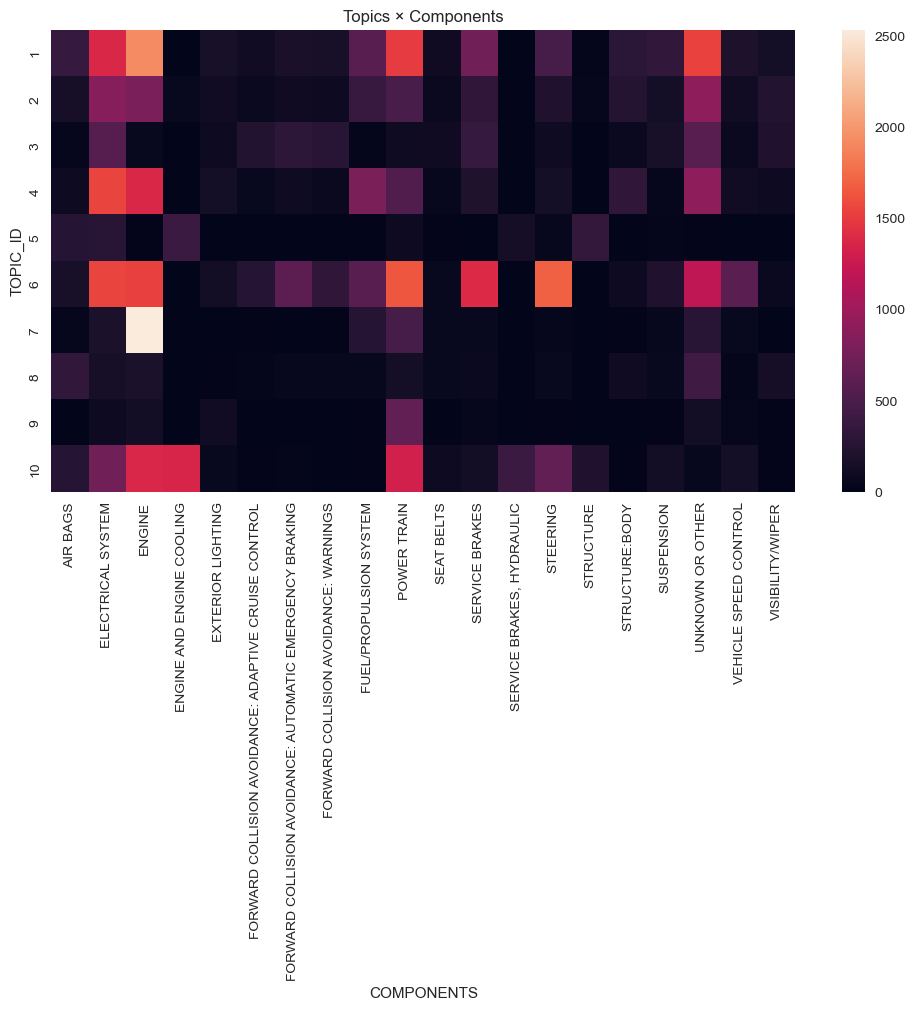

In [14]:
doc_topic = lda_model.transform(X)
complaints_agg['TOPIC_ID'] = doc_topic.argmax(axis=1) + 1
complaints_agg['TOPIC_SCORE'] = doc_topic.max(axis=1)

# Distribución por tema
topic_counts = complaints_agg['TOPIC_ID'].value_counts().sort_index()
display(topic_counts)

# Cruce TEMA × COMPONENTE (explotando la lista)
cross_comp = (
    complaints_agg
      .explode('COMPONENTS')
      .dropna(subset=['COMPONENTS'])
      .groupby(['TOPIC_ID','COMPONENTS'])
      .size()
      .reset_index(name='n')
      .sort_values('n', ascending=False)
)

display(cross_comp.head(20))

# Heatmap (temas vs top componentes):

top_comps = cross_comp.groupby('COMPONENTS')['n'].sum().sort_values(ascending=False).head(20).index
heat = (cross_comp[cross_comp['COMPONENTS'].isin(top_comps)]
        .pivot(index='TOPIC_ID', columns='COMPONENTS', values='n')
        .fillna(0))

plt.figure(figsize=(12,6)); sns.heatmap(heat, annot=False); plt.title('Topics × Components'); plt.show()

# Embedding e5-base-v2

In [51]:
def load_embedding_model():
    tried = []
    for name in [
        "nomic-ai/ModernBERT-base",                # opción moderna
        "intfloat/e5-base-v2",                     # muy sólido para similitud/búsqueda
        "sentence-transformers/all-MiniLM-L6-v2",  # ligero y rápido
    ]:
        try:
            m = SentenceTransformer(name)
            print(f"✓ Modelo de embeddings cargado: {name}")
            return m
        except Exception as e:
            tried.append((name, str(e)))
    raise RuntimeError(f"No se pudo cargar un modelo. Intentos: {tried}")

emb_model = load_embedding_model()

# Asegúrate de tener la columna de texto limpia
TEXT_COL = "CLEAN_TEXT"
assert TEXT_COL in df.columns, "No se encontró la columna CLEAN_TEXT"

No sentence-transformers model found with name nomic-ai/ModernBERT-base. Creating a new one with mean pooling.


✓ Modelo de embeddings cargado: intfloat/e5-base-v2


In [ ]:
texts = df[TEXT_COL].fillna("").astype(str).tolist()

# encode devuelve np.array si convert_to_numpy=True
embeddings = emb_model.encode(
    texts,
    batch_size=64,
    convert_to_numpy=True,
    show_progress_bar=True,
    normalize_embeddings=True   # normaliza internamente si tu versión lo permite
)

# Por compatibilidad, normalizamos de nuevo si fuese necesario
embeddings = normalize(embeddings)  # (n_docs, dim)
print(embeddings.shape, embeddings.dtype)



Batches:   0%|          | 0/931 [00:00<?, ?it/s]

(59548, 768) float32


NameError: name 'os' is not defined

In [54]:
# Guarda a disco para reusar en otras fases
os.makedirs("embeddings", exist_ok=True)
np.save("embeddings/complaints_embeddings.npy", embeddings.astype("float32"))

In [55]:
# Keys canónicas de vehículo
veh_keys = (df["MAKE"].fillna("").astype(str).str.strip() + " " +
            df["MODEL"].fillna("").astype(str).str.strip() + " (" +
            df["YEAR"].fillna("").astype(str) + ")")

df["VEHICLE_KEY"] = veh_keys.str.replace(r"\s+", " ", regex=True).str.strip()

unique_components = sorted(df["COMPONENT"].dropna().astype(str).str.strip().unique().tolist())
unique_makes      = sorted(df["MAKE"].dropna().astype(str).str.strip().unique().tolist())
unique_models     = sorted(df["MODEL"].dropna().astype(str).str.strip().unique().tolist())
unique_vehicle_keys = sorted(df["VEHICLE_KEY"].dropna().astype(str).str.strip().unique().tolist())

def encode_list(strings):
    if not strings: 
        return np.empty((0, embeddings.shape[1]), dtype="float32")
    vecs = emb_model.encode(strings, batch_size=128, convert_to_numpy=True, show_progress_bar=True)
    vecs = normalize(vecs).astype("float32")
    return vecs

comp_emb  = encode_list(unique_components)
make_emb  = encode_list(unique_makes)
model_emb = encode_list(unique_models)
veh_emb   = encode_list(unique_vehicle_keys)

np.save("embeddings/components_embeddings.npy", comp_emb)
np.save("embeddings/makes_embeddings.npy", make_emb)
np.save("embeddings/models_embeddings.npy", model_emb)
np.save("embeddings/vehicles_embeddings.npy", veh_emb)

print("COMPONENTS:", comp_emb.shape, 
      "MAKES:", make_emb.shape, 
      "MODELS:", model_emb.shape, 
      "VEH:", veh_emb.shape)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

COMPONENTS: (344, 768) MAKES: (147, 768) MODELS: (1106, 768) VEH: (4533, 768)


## Embeddings ModernBERT

In [1]:
from sentence_transformers import SentenceTransformer, models

# Puedes probar con alguno de estos nombres según disponibilidad en tu entorno:
# "answerdotai/ModernBERT-base"   (suele aparecer como ModernBERT-base)
# "answerdotai/ModernBERT-large"  (más pesado)
# Si el que usaste fue "nomic-ai/ModernBERT-base" y te funcionó la descarga, usa ese string aquí.

hf_model_name = "answerdotai/ModernBERT-large"  # ajusta al que tengas disponible

# 1) Capa Transformer
word_embedding_model = models.Transformer(
    hf_model_name,
    max_seq_length=4096  # sube a 4096/8192 solo si tienes RAM/GPU suficiente
)

# 2) Pooling (mean pooling, el estándar para embeddings de frases)
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

# 3) Ensamblar SentenceTransformer
emb_model_modernbert = SentenceTransformer(modules=[word_embedding_model, pooling_model])

print("✓ ModernBERT envuelto correctamente como SentenceTransformer")


✓ ModernBERT envuelto correctamente como SentenceTransformer


In [24]:
texts = df[TEXT_COL].fillna("").astype(str).tolist()

# encode devuelve np.array si convert_to_numpy=True
embeddings_modernbert = emb_model_modernbert.encode(
    texts,
    batch_size=128,
    convert_to_numpy=True,
    show_progress_bar=True,
    normalize_embeddings=True   # normaliza internamente si tu versión lo permite
)

# Por compatibilidad, normalizamos de nuevo si fuese necesario
embeddings_mbert = normalize(embeddings_modernbert)  # (n_docs, dim)
print(embeddings_mbert.shape, embeddings_mbert.dtype)

Batches:   0%|          | 0/466 [00:00<?, ?it/s]

(59548, 1024) float32


In [27]:
os.makedirs("embeddings_mbert", exist_ok=True)
np.save("embeddings_mbert/complaints_embeddings_mbert4096.npy", embeddings_mbert.astype("float32"))

In [16]:
import numpy as np

# Cargar los embeddings previamente guardados
embeddings_mbert = np.load("embeddings_mbert/complaints_embeddings_mbert4096.npy")

print("Embeddings cargados correctamente.")
print("Forma:", embeddings_mbert.shape)
print("Tipo de dato:", embeddings_mbert.dtype)

Embeddings cargados correctamente.
Forma: (59548, 1024)
Tipo de dato: float32


In [18]:
assert len(df) == embeddings_mbert.shape[0], \
    f"Los embeddings ({embeddings_mbert.shape[0]}) no coinciden con las filas del DataFrame ({len(df)})"

In [28]:
# Keys canónicas de vehículo
veh_keys = (df["MAKE"].fillna("").astype(str).str.strip() + " " +
            df["MODEL"].fillna("").astype(str).str.strip() + " (" +
            df["YEAR"].fillna("").astype(str) + ")")

df["VEHICLE_KEY"] = veh_keys.str.replace(r"\s+", " ", regex=True).str.strip()

unique_components = sorted(df["COMPONENT"].dropna().astype(str).str.strip().unique().tolist())
unique_makes      = sorted(df["MAKE"].dropna().astype(str).str.strip().unique().tolist())
unique_models     = sorted(df["MODEL"].dropna().astype(str).str.strip().unique().tolist())
unique_vehicle_keys = sorted(df["VEHICLE_KEY"].dropna().astype(str).str.strip().unique().tolist())

def encode_list(strings):
    if not strings: 
        return np.empty((0, embeddings_mbert.shape[1]), dtype="float32")
    vecs = emb_model_modernbert.encode(strings, batch_size=128, convert_to_numpy=True, show_progress_bar=True)
    vecs = normalize(vecs).astype("float32")
    return vecs

comp_emb  = encode_list(unique_components)
make_emb  = encode_list(unique_makes)
model_emb = encode_list(unique_models)
veh_emb   = encode_list(unique_vehicle_keys)

np.save("embeddings_mbert/components_embeddings.npy", comp_emb)
np.save("embeddings_mbert/makes_embeddings.npy", make_emb)
np.save("embeddings_mbert/models_embeddings.npy", model_emb)
np.save("embeddings_mbert/vehicles_embeddings.npy", veh_emb)

print("COMPONENTS:", comp_emb.shape, 
      "MAKES:", make_emb.shape, 
      "MODELS:", model_emb.shape, 
      "VEH:", veh_emb.shape)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

COMPONENTS: (344, 1024) MAKES: (147, 1024) MODELS: (1106, 1024) VEH: (4533, 1024)


In [29]:
# Mapeos índice
comp_to_idx = {c:i for i,c in enumerate(unique_components)}

# sample para rapidez
sample_idx = np.random.RandomState(42).choice(len(df), size=min(5000, len(df)), replace=False)
pos_sims = []

for idx in tqdm(sample_idx, desc="Calibrando similitud texto→COMPONENT"):
    comp = df.iloc[idx]["COMPONENT"]
    if pd.isna(comp) or comp not in comp_to_idx:
        continue
    j = comp_to_idx[comp]
    s = float((embeddings_mbert[idx:idx+1] @ comp_emb[j:j+1].T)[0,0])  # coseno por normalización
    pos_sims.append(s)

pos_sims = np.array(pos_sims)
print("Pos-sims size:", len(pos_sims))
print("Percentiles positivos:", 
      np.percentile(pos_sims, [10,25,50,75,90,95,99]))
# Sugerencia de umbral preliminar
THR_TXT_TO_COMPONENT = float(np.percentile(pos_sims, 25))
print("Umbral sugerido texto→COMPONENT:", THR_TXT_TO_COMPONENT)

Calibrando similitud texto→COMPONENT: 100%|██████████| 5000/5000 [00:00<00:00, 12325.45it/s]

Pos-sims size: 5000
Percentiles positivos: [0.52771513 0.56500436 0.60809454 0.6495344  0.70140404 0.73689615
 0.78832912]
Umbral sugerido texto→COMPONENT: 0.565004363656044


## Nombramiento de entidades

NER (Reconocimiento de Entidades Nombradas) te permite extraer automáticamente entidades concretas de los textos, esto servirá más adelante para alimentar los grafos de conocimiento.

### Reglas de dominio con EntityRuler (pisan a NER)


Creamos un label custom (por ejemplo COMPONENT_MSG) o usamos uno propio COMPONENT. Añadimos patrones para mensajes conocidos y componentes del dat

In [ ]:
nlp = spacy.load("en_core_web_sm")

ruler = nlp.add_pipe("entity_ruler", before="ner")  # importante: antes del NER
patterns = []

# 1) Mensajes comunes de tablero
msgs = [
    "check brake system", "collision assist unavailable", "engine light",
    "service brake system", "check engine", "service transmission",
    "power steering assist fault", "brake is not on"
]
patterns += [{"label": "COMPONENT_MSG", "pattern": m} for m in msgs]

# 2) Componentes conocidos (puedes cargar desde df['COMPONENT'].unique())
components_vocab = {
    "ENGINE","TRANSMISSION","BRAKE","BRAKES","AIR BAG","AIRBAG","POWER STEERING",
    "FUEL INJECTOR","COOLING SYSTEM","ELECTRICAL SYSTEM","BATTERY","WIRING",
    "SEAT BELT","SEATBELT","TIRE","TIRES","AXLE","FRAME","SUNROOF","HEADLIGHT"
}
patterns += [{"label": "COMPONENT", "pattern": c.lower()} for c in components_vocab]

ruler.add_patterns(patterns)

In [23]:
nlp = spacy.load("en_core_web_sm")

# Muestra una pequeña muestra de textos para extracción de entidades
sample_texts = df['CLEAN_TEXT'].dropna().sample(10, random_state=42)

entity_counts = Counter()
for doc in nlp.pipe(sample_texts, batch_size=10):
    entity_counts.update([ent.label_ for ent in doc.ents])

print("Etiquetas de entidades más frecuentes:")
print(entity_counts.most_common(10))

Etiquetas de entidades más frecuentes:
[('CARDINAL', 20), ('DATE', 12), ('QUANTITY', 4), ('ORG', 4), ('ORDINAL', 3), ('PERSON', 1)]


In [ ]:
# Para rendimiento, procesa una muestra (ajusta n_docs según tu RAM/tiempo)
n_docs = min(5000, len(df))
sample_texts = complaints_agg["DOC_TEXT"].dropna().astype(str).head(n_docs).tolist()

ents = []
for i, doc in enumerate(nlp.pipe(sample_texts, batch_size=64, disable=["parser","tagger"])):
    for e in doc.ents:
        ents.append((i, e.text, e.label_))

ner_df = pd.DataFrame(ents, columns=['doc_idx','entity','label'])
display(ner_df.head())

# Top entidades por tipo
top_by_label = (ner_df.groupby(['label','entity']).size()
                       .reset_index(name='n')
                       .sort_values(['label','n'], ascending=[True, False]))
display(top_by_label.groupby('label').head(10))


,doc_idx,entity,label
0,0,engine,COMPONENT
1,0,power steering,COMPONENT
2,1,engine,COMPONENT
3,1,engine,COMPONENT
4,1,engine,COMPONENT


,label,entity,n
332,CARDINAL,2,275
1313,CARDINAL,one,274
808,CARDINAL,5,269
657,CARDINAL,3,188
1340,CARDINAL,two,184
...,...,...,...
4845,TIME,30 minute,16
4806,TIME,15 minute,12
4891,TIME,afternoon,12
4820,TIME,20 minute,10


In [ ]:

sample = complaints_agg["DOC_TEXT"].dropna().sample(3, random_state=42).tolist()
docs = list(nlp.pipe(sample))
for d in docs:
    displacy.render(d, style="ent", jupyter=True, options={"colors": {"COMPONENT":"#8dd3c7","COMPONENT_MSG":"#ffffb3"}})

c:\Users\moral\anaconda3\Lib\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


c:\Users\moral\anaconda3\Lib\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


c:\Users\moral\anaconda3\Lib\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [33]:
ents = []
for doc in nlp.pipe(complaints_agg["DOC_TEXT"].dropna().astype(str).head(5000), batch_size=64):
    ents += [(e.text, e.label_) for e in doc.ents]

ner_df = pd.DataFrame(ents, columns=["entity","label"])
display(ner_df["label"].value_counts().head(20))
display(ner_df.groupby("label").head(10))

label
COMPONENT        6536
CARDINAL         5608
DATE             4217
ORG              2448
QUANTITY         1947
ORDINAL           727
PERSON            610
TIME              579
COMPONENT_MSG     548
PRODUCT           280
GPE               258
MONEY              47
NORP               41
FAC                36
LOC                24
LAW                 9
PERCENT             7
EVENT               3
WORK_OF_ART         1
Name: count, dtype: int64

,entity,label
0,engine,COMPONENT
1,power steering,COMPONENT
2,engine,COMPONENT
3,engine,COMPONENT
4,engine,COMPONENT
...,...,...
15100,cyl 3,LAW
19735,elantra,LAW
20688,1 gdi,PERCENT
22326,chapter 7bankrupty,LAW


## Generar grafos de conocimiento

In [30]:
# utilidades de similitud en lotes para no agotar memoria
def batched_topk_sims(A, B, topk=3, batch=1024):
    # A: (n, d)  B: (m, d)  dev: listas [(idxA, idxB, score), ...]
    out = []
    for i in tqdm(range(0, A.shape[0], batch), desc="Buscando vecinos por similitud"):
        Ai = A[i:i+batch]          # (b, d)
        S = Ai @ B.T               # (b, m) coseno por normalización
        top_idx = np.argpartition(-S, kth=min(topk, S.shape[1]-1), axis=1)[:, :topk]
        # ordenar dentro del topk
        rows = np.arange(S.shape[0])[:, None]
        vals = np.take_along_axis(S, top_idx, axis=1)
        order = np.argsort(-vals, axis=1)
        top_sorted = np.take_along_axis(top_idx, order, axis=1)
        vals_sorted = np.take_along_axis(vals, order, axis=1)
        for r in range(top_sorted.shape[0]):
            a_idx = i + r
            for c in range(top_sorted.shape[1]):
                b_idx = int(top_sorted[r, c])
                score = float(vals_sorted[r, c])
                out.append((a_idx, b_idx, score))
    return out

# Texto → COMPONENT
txt_to_comp_candidates = batched_topk_sims(embeddings_mbert, comp_emb, topk=3, batch=1024)
edges_txt_comp = [
    (int(a), unique_components[int(b)], float(s))
    for (a,b,s) in txt_to_comp_candidates
    if s >= THR_TXT_TO_COMPONENT
]

# Opcional: Texto → VEHICLE_KEY (puede ser útil cuando no está claro el modelo)
veh_to_idx = {v:i for i,v in enumerate(unique_vehicle_keys)}
txt_to_veh_candidates = batched_topk_sims(embeddings_mbert, veh_emb, topk=1, batch=1024)
# usa un umbral algo más alto porque vehicle labels suelen ser informativas
THR_TXT_TO_VEH = 0.4
edges_txt_veh = [
    (int(a), unique_vehicle_keys[int(b)], float(s))
    for (a,b,s) in txt_to_veh_candidates
    if s >= THR_TXT_TO_VEH
]

print("Aristas texto→COMPONENT (post-umbral):", len(edges_txt_comp))
print("Aristas texto→VEHICLE_KEY (post-umbral):", len(edges_txt_veh))

Buscando vecinos por similitud: 100%|██████████| 59/59 [00:03<00:00, 18.63it/s]

Aristas texto→COMPONENT (post-umbral): 175397
Aristas texto→VEHICLE_KEY (post-umbral): 59548


In [31]:
# Nodos
nodes = []

# Nodos de QUEJA (usa índice del df como id)
for i, row in df.reset_index().iterrows():
    nodes.append({
        "id": f"complaint_{i}",
        "type": "complaint",
        "miles": row.get("MILES", np.nan),
        "vehspeed": row.get("VEHSPEED", np.nan),
        "injured": row.get("INJURED", np.nan),
        "deaths": row.get("DEATHS", np.nan)
    })

# Nodos de COMPONENT
for c in unique_components:
    nodes.append({"id": f"component_{c}", "type": "component"})

# Nodos de VEHICLE
for v in unique_vehicle_keys:
    nodes.append({"id": f"vehicle_{v}", "type": "vehicle"})

nodes_df = pd.DataFrame(nodes)

# Aristas
edges = []

# complaint -> component (por similitud)
for a_idx, comp_str, score in edges_txt_comp:
    edges.append({
        "source": f"complaint_{a_idx}",
        "target": f"component_{comp_str}",
        "relation": "mentions_component_semantic",
        "weight": round(score, 4)
    })

# complaint -> vehicle (por similitud)
for a_idx, veh_str, score in edges_txt_veh:
    edges.append({
        "source": f"complaint_{a_idx}",
        "target": f"vehicle_{veh_str}",
        "relation": "mentions_vehicle_semantic",
        "weight": round(score, 4)
    })

edges_df = pd.DataFrame(edges)

os.makedirs("results", exist_ok=True)
nodes_df.to_csv("results/graph_nodes_embeddings.csv", index=False)
edges_df.to_csv("results/graph_edges_embeddings.csv", index=False)

nodes_df.head(), edges_df.head()


(            id       type  miles  vehspeed  injured  deaths
 0  complaint_0  complaint    NaN      35.0      0.0     0.0
 1  complaint_1  complaint    NaN      35.0      0.0     0.0
 2  complaint_2  complaint    NaN      40.0      0.0     0.0
 3  complaint_3  complaint    NaN      40.0      0.0     0.0
 4  complaint_4  complaint    NaN       NaN      0.0     0.0,
         source                                             target  \
 0  complaint_0  component_SERVICE BRAKES, HYDRAULIC:ANTILOCK/T...   
 1  complaint_0   component_FUEL SYSTEM, DIESEL:DELIVERY:FUEL PUMP   
 2  complaint_0  component_ELECTRICAL SYSTEM:PROPULSION SYSTEM:...   
 3  complaint_1  component_SERVICE BRAKES, HYDRAULIC:ANTILOCK/T...   
 4  complaint_1   component_FUEL SYSTEM, DIESEL:DELIVERY:FUEL PUMP   
 
                       relation  weight  
 0  mentions_component_semantic  0.6940  
 1  mentions_component_semantic  0.6859  
 2  mentions_component_semantic  0.6854  
 3  mentions_component_semantic  0.6940  
 

In [32]:
def nearest_complaints(idx, k=5):
    sims = (embeddings_mbert[idx:idx+1] @ embeddings_mbert.T).ravel()
    order = sims.argsort()[-(k+1):][::-1]  # +1 para excluirse a sí mismo
    out = [(j, float(sims[j])) for j in order if j != idx][:k]
    return out

probe = 123  # elige una fila de tu df
print("Texto:", df.iloc[probe][TEXT_COL][:300], "...")
print("Vecinos más similares:")
for j, s in nearest_complaints(probe, k=5):
    print(f"- idx={j} sim={s:.3f} | COMPONENT={df.iloc[j]['COMPONENT']} | VEHICLE={df.iloc[j]['VEHICLE_KEY']}")


Texto: contact owns 2014 ford fusion contact stated driving undisclosed speed transmission unexpectedly downshifted warning light illuminated vehicle taken independent mechanic diagnosed transmission failure contact informed transmission needed replaced dealer contacted vehicle diagnosed repaired manufactu ...
Vecinos más similares:
- idx=1139 sim=0.984 | COMPONENT=POWER TRAIN | VEHICLE=FORD F-150 (2018)
- idx=13165 sim=0.981 | COMPONENT=ENGINE | VEHICLE=FORD FOCUS (2018)
- idx=13164 sim=0.981 | COMPONENT=POWER TRAIN | VEHICLE=FORD FOCUS (2018)
- idx=4827 sim=0.981 | COMPONENT=POWER TRAIN:AUTOMATIC TRANSMISSION | VEHICLE=FORD EDGE (2023)
- idx=43691 sim=0.980 | COMPONENT=POWER TRAIN | VEHICLE=GMC ACADIA (2017)
